In [37]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers

# Defining the global variables.
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 30
# Training for single epoch for time constraint.
# Please use atleast 30 epochs to see good results.
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
 ! mkdir ~/.kaggle

In [8]:
!ls

drive  sample_data


In [9]:

#! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ikarus777/best-artworks-of-all-time
! unzip -qq best-artworks-of-all-time.zip
! rm -rf images
! mv resized artwork
! rm best-artworks-of-all-time.zip artists.csv

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time
License(s): CC-BY-NC-SA-4.0
 99% 2.28G/2.29G [00:21<00:00, 123MB/s] 
100% 2.29G/2.29G [00:21<00:00, 113MB/s]


In [10]:

! kaggle datasets download  -d atulanandjha/lfwpeople
import zipfile
zip_ref = zipfile.ZipFile('lfwpeople.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()



Dataset URL: https://www.kaggle.com/datasets/atulanandjha/lfwpeople
License(s): GNU Lesser General Public License 3.0
 90% 208M/232M [00:02<00:00, 102MB/s] 
100% 232M/232M [00:02<00:00, 113MB/s]


In [11]:
!ls

artwork  lfw-funneled.tgz  pairsDevTest.txt   pairs.txt
drive	 lfwpeople.zip	   pairsDevTrain.txt  sample_data


In [12]:
import tarfile

# Unzip the lfw-funneled.tgz file
tar_path = '/content/lfw-funneled.tgz'
extract_path = '/content/lfw-funneled'

# Open the tar.gz file
with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

# Check the contents of the extracted directory
import os
extracted_files = os.listdir(extract_path)
print("Extracted files:", extracted_files)

# Optionally, list some image files to confirm
image_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(extract_path) for f in filenames if os.path.splitext(f)[1] == '.jpg']
print("Sample images:", image_files[:10])  # Displaying only the first 10 image paths

Extracted files: ['lfw_funneled']
Sample images: ['/content/lfw-funneled/lfw_funneled/Carlos_Fasciolo/Carlos_Fasciolo_0001.jpg', '/content/lfw-funneled/lfw_funneled/Julie_Andrews/Julie_Andrews_0001.jpg', '/content/lfw-funneled/lfw_funneled/Guillaume_Soro/Guillaume_Soro_0001.jpg', '/content/lfw-funneled/lfw_funneled/Guillaume_Soro/Guillaume_Soro_0002.jpg', '/content/lfw-funneled/lfw_funneled/Ellen_Pompeo/Ellen_Pompeo_0001.jpg', '/content/lfw-funneled/lfw_funneled/Salman_Khan/Salman_Khan_0001.jpg', '/content/lfw-funneled/lfw_funneled/Mikhail_Kasyanov/Mikhail_Kasyanov_0003.jpg', '/content/lfw-funneled/lfw_funneled/Mikhail_Kasyanov/Mikhail_Kasyanov_0002.jpg', '/content/lfw-funneled/lfw_funneled/Mikhail_Kasyanov/Mikhail_Kasyanov_0001.jpg', '/content/lfw-funneled/lfw_funneled/Mikhail_Kasyanov/Mikhail_Kasyanov_0004.jpg']


In [13]:
import os
import numpy as np

# Shuffle the image files to randomize the input
np.random.shuffle(image_files)

# Split into training, validation, and test sets (e.g., 80%, 10%, 10%)
num_images = len(image_files)
train_end = int(num_images * 0.8)
val_end = int(num_images * 0.9)

train_files = image_files[:train_end]
val_files = image_files[train_end:val_end]
test_files = ['/content/lfw-funneled/lfw_funneled/Anthony_Ervin/Anthony_Ervin_0001.jpg',
 '/content/lfw-funneled/lfw_funneled/Roh_Moo-hyun/Roh_Moo-hyun_0022.jpg',
 '/content/lfw-funneled/lfw_funneled/Julianne_Moore/Julianne_Moore_0016.jpg',
 '/content/lfw-funneled/lfw_funneled/Gonzalo_Sanchez_de_Lozada/Gonzalo_Sanchez_de_Lozada_0005.jpg',
 '/content/lfw-funneled/lfw_funneled/Paul_Hogan/Paul_Hogan_0002.jpg',
 '/content/lfw-funneled/lfw_funneled/Phil_Bennett/Phil_Bennett_0001.jpg',
 '/content/lfw-funneled/lfw_funneled/Hamid_Karzai/Hamid_Karzai_0019.jpg',
 '/content/lfw-funneled/lfw_funneled/George_W_Bush/George_W_Bush_0256.jpg',
 '/content/lfw-funneled/lfw_funneled/Daniel_Darnell/Daniel_Darnell_0001.jpg',
 '/content/lfw-funneled/lfw_funneled/Queen_Elizabeth_II/Queen_Elizabeth_II_0005.jpg']


In [31]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Adjust size as needed for your model
    image = (image / 255.0)  # Normalize to [0, 1]
    return image


In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_content_ds = (
    tf.data.Dataset.from_tensor_slices(train_files)
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .repeat()
)

val_content_ds = (
    tf.data.Dataset.from_tensor_slices(val_files)
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .repeat()
)

test_content_ds = (
    tf.data.Dataset.from_tensor_slices(test_files)
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .repeat()
)


In [16]:
def decode_and_resize(image_path):
    """Decodes and resizes an image from the image file path.

    Args:
        image_path: The image file path.

    Returns:
        A resized image.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


def extract_image_from_voc(element):
    """Extracts image from the PascalVOC dataset.

    Args:
        element: A dictionary of data.

    Returns:
        A resized image.
    """
    image = element["image"]
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image


# Get the image file paths for the style images.
style_images = os.listdir("/content/artwork/resized")
style_images = [os.path.join("/content/artwork/resized", path) for path in style_images]

# split the style images in train, val and test
total_style_images = len(style_images)
train_style = style_images[: int(0.8 * total_style_images)]
val_style = style_images[int(0.8 * total_style_images) : int(0.9 * total_style_images)]
test_style = style_images[int(0.9 * total_style_images) :]

# Build the style and content tf.data datasets.
train_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
# train_content_ds = tfds.load("voc", split="train").map(extract_image_from_voc).repeat()

val_style_ds = (
    tf.data.Dataset.from_tensor_slices(val_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
# val_content_ds = (
#     tfds.load("voc", split="validation").map(extract_image_from_voc).repeat()
# )

test_style_ds = (
    tf.data.Dataset.from_tensor_slices(test_style)
    .map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    .repeat()
)
# test_content_ds = (
#     tfds.load("voc", split="test")
#     .map(extract_image_from_voc, num_parallel_calls=AUTOTUNE)
#     .repeat()
# )

# Zipping the style and content datasets.
train_ds = (
    tf.data.Dataset.zip((train_style_ds, train_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.zip((val_style_ds, val_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.zip((test_style_ds, test_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

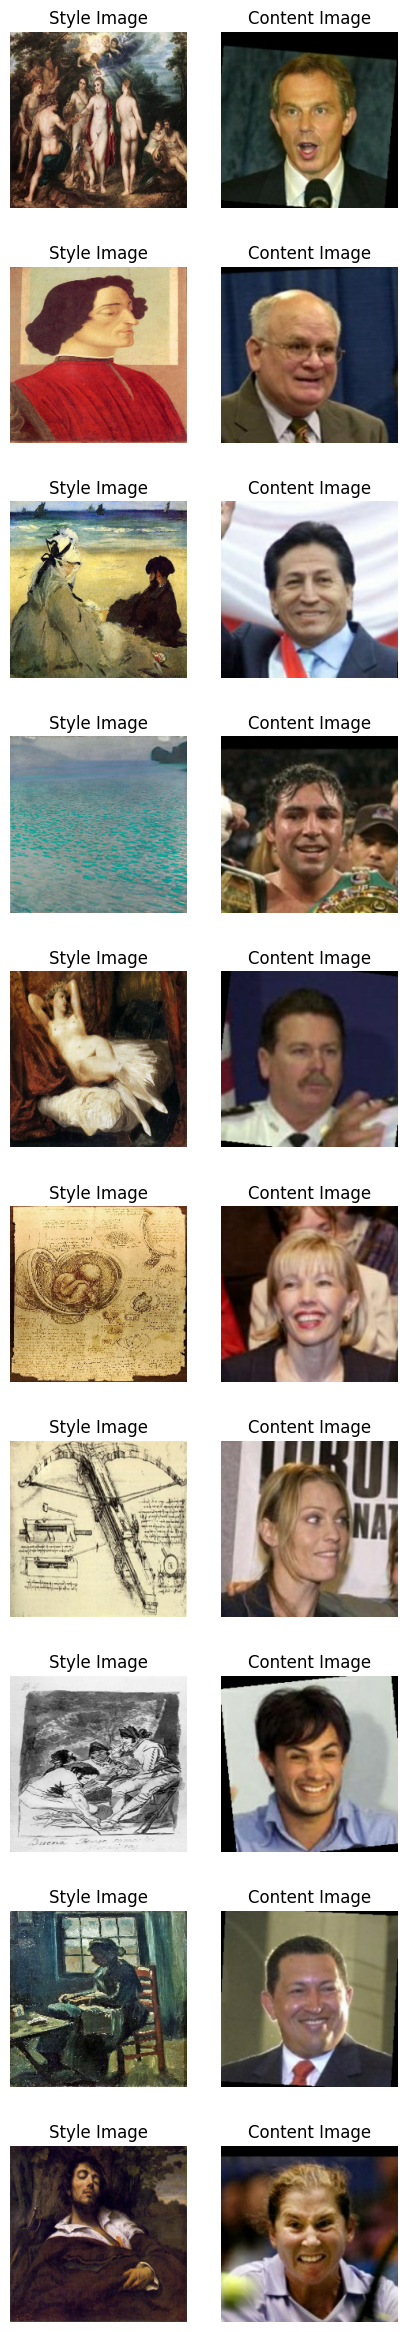

In [17]:
style, content = next(iter(train_ds))
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(5, 30))
[ax.axis("off") for ax in np.ravel(axes)]

for (axis, style_image, content_image) in zip(axes, style[0:10], content[0:10]):
    (ax_style, ax_content) = axis
    ax_style.imshow(style_image)
    ax_style.set_title("Style Image")

    ax_content.imshow(content_image)
    ax_content.set_title("Content Image")

In [18]:
def get_encoder():
    vgg19 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(*IMAGE_SIZE, 3),
    )
    vgg19.trainable = False
    mini_vgg19 = keras.Model(vgg19.input, vgg19.get_layer("block4_conv1").output)

    inputs = layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out, name="mini_vgg19")

In [19]:
def get_mean_std(x, epsilon=1e-5):
    axes = [1, 2]

    # Compute the mean and standard deviation of a tensor.
    mean, variance = tf.nn.moments(x, axes=axes, keepdims=True)
    standard_deviation = tf.sqrt(variance + epsilon)
    return mean, standard_deviation


def ada_in(style, content):
    """Computes the AdaIn feature map.

    Args:
        style: The style feature map.
        content: The content feature map.

    Returns:
        The AdaIN feature map.
    """
    content_mean, content_std = get_mean_std(content)
    style_mean, style_std = get_mean_std(style)
    t = style_std * (content - content_mean) / content_std + style_mean
    return t

In [20]:
def get_decoder():
    config = {"kernel_size": 3, "strides": 1, "padding": "same", "activation": "relu"}
    decoder = keras.Sequential(
        [
            layers.InputLayer((None, None, 512)),
            layers.Conv2D(filters=512, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=128, **config),
            layers.Conv2D(filters=128, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=64, **config),
            layers.Conv2D(
                filters=3,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="sigmoid",
            ),
        ]
    )
    return decoder


In [21]:
def get_mean_std(x, epsilon=1e-5):
    axes = [1, 2]

    # Compute the mean and standard deviation of a tensor.
    mean, variance = tf.nn.moments(x, axes=axes, keepdims=True)
    standard_deviation = tf.sqrt(variance + epsilon)
    return mean, standard_deviation


def ada_in(style, content):
    """Computes the AdaIn feature map.

    Args:
        style: The style feature map.
        content: The content feature map.

    Returns:
        The AdaIN feature map.
    """
    content_mean, content_std = get_mean_std(content)
    style_mean, style_std = get_mean_std(style)
    t = style_std * (content - content_mean) / content_std + style_mean
    return t

In [22]:
def get_decoder():
    config = {"kernel_size": 3, "strides": 1, "padding": "same", "activation": "relu"}
    decoder = keras.Sequential(
        [
            layers.InputLayer((None, None, 512)),
            layers.Conv2D(filters=512, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.Conv2D(filters=256, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=128, **config),
            layers.Conv2D(filters=128, **config),
            layers.UpSampling2D(),
            layers.Conv2D(filters=64, **config),
            layers.Conv2D(
                filters=3,
                kernel_size=3,
                strides=1,
                padding="same",
                activation="sigmoid",
            ),
        ]
    )
    return decoder

In [23]:
def get_loss_net():
    vgg19 = keras.applications.VGG19(
        include_top=False, weights="imagenet", input_shape=(*IMAGE_SIZE, 3)
    )
    vgg19.trainable = False
    layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    outputs = [vgg19.get_layer(name).output for name in layer_names]
    mini_vgg19 = keras.Model(vgg19.input, outputs)

    inputs = layers.Input([*IMAGE_SIZE, 3])
    mini_vgg19_out = mini_vgg19(inputs)
    return keras.Model(inputs, mini_vgg19_out, name="loss_net")

In [24]:
class NeuralStyleTransfer(tf.keras.Model):
    def __init__(self, encoder, decoder, loss_net, style_weight, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_net = loss_net
        self.style_weight = style_weight

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.style_loss_tracker = keras.metrics.Mean(name="style_loss")
        self.content_loss_tracker = keras.metrics.Mean(name="content_loss")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        with tf.GradientTape() as tape:
            # Encode the style and content image.
            style_encoded = self.encoder(style)
            content_encoded = self.encoder(content)

            # Compute the AdaIN target feature maps.
            t = ada_in(style=style_encoded, content=content_encoded)

            # Generate the neural style transferred image.
            reconstructed_image = self.decoder(t)

            # Compute the losses.
            reconstructed_vgg_features = self.loss_net(reconstructed_image)
            style_vgg_features = self.loss_net(style)
            loss_content = self.loss_fn(t, reconstructed_vgg_features[-1])
            for inp, out in zip(style_vgg_features, reconstructed_vgg_features):
                mean_inp, std_inp = get_mean_std(inp)
                mean_out, std_out = get_mean_std(out)
                loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                    std_inp, std_out
                )
            loss_style = self.style_weight * loss_style
            total_loss = loss_content + loss_style

        # Compute gradients and optimize the decoder.
        trainable_vars = self.decoder.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def test_step(self, inputs):
        style, content = inputs

        # Initialize the content and style loss.
        loss_content = 0.0
        loss_style = 0.0

        # Encode the style and content image.
        style_encoded = self.encoder(style)
        content_encoded = self.encoder(content)

        # Compute the AdaIN target feature maps.
        t = ada_in(style=style_encoded, content=content_encoded)

        # Generate the neural style transferred image.
        reconstructed_image = self.decoder(t)

        # Compute the losses.
        recons_vgg_features = self.loss_net(reconstructed_image)
        style_vgg_features = self.loss_net(style)
        loss_content = self.loss_fn(t, recons_vgg_features[-1])
        for inp, out in zip(style_vgg_features, recons_vgg_features):
            mean_inp, std_inp = get_mean_std(inp)
            mean_out, std_out = get_mean_std(out)
            loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(
                std_inp, std_out
            )
        loss_style = self.style_weight * loss_style
        total_loss = loss_content + loss_style

        # Update the trackers.
        self.style_loss_tracker.update_state(loss_style)
        self.content_loss_tracker.update_state(loss_content)
        self.total_loss_tracker.update_state(total_loss)
        return {
            "style_loss": self.style_loss_tracker.result(),
            "content_loss": self.content_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    @property
    def metrics(self):
        return [
            self.style_loss_tracker,
            self.content_loss_tracker,
            self.total_loss_tracker,
        ]

In [25]:
test_style, test_content = next(iter(test_ds))


class TrainMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Encode the style and content image.
        test_style_encoded = self.model.encoder(test_style)
        test_content_encoded = self.model.encoder(test_content)

        # Compute the AdaIN features.
        test_t = ada_in(style=test_style_encoded, content=test_content_encoded)
        test_reconstructed_image = self.model.decoder(test_t)

        # Plot the Style, Content and the NST image.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(tf.keras.utils.array_to_img(test_style[0]))
        ax[0].set_title(f"Style: {epoch:03d}")

        ax[1].imshow(tf.keras.utils.array_to_img(test_content[0]))
        ax[1].set_title(f"Content: {epoch:03d}")

        ax[2].imshow(
            tf.keras.utils.array_to_img(test_reconstructed_image[0])
        )
        ax[2].set_title(f"NST: {epoch:03d}")

        plt.show()
        plt.close()

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
loss_fn = keras.losses.MeanSquaredError()

encoder = get_encoder()
loss_net = get_loss_net()
decoder = get_decoder()

model = NeuralStyleTransfer(
    encoder=encoder, decoder=decoder, loss_net=loss_net, style_weight=4.0
)

model.compile(optimizer=optimizer, loss_fn=loss_fn)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=50,
    validation_data=val_ds,
    validation_steps=50,
    callbacks=[TrainMonitor()],
)

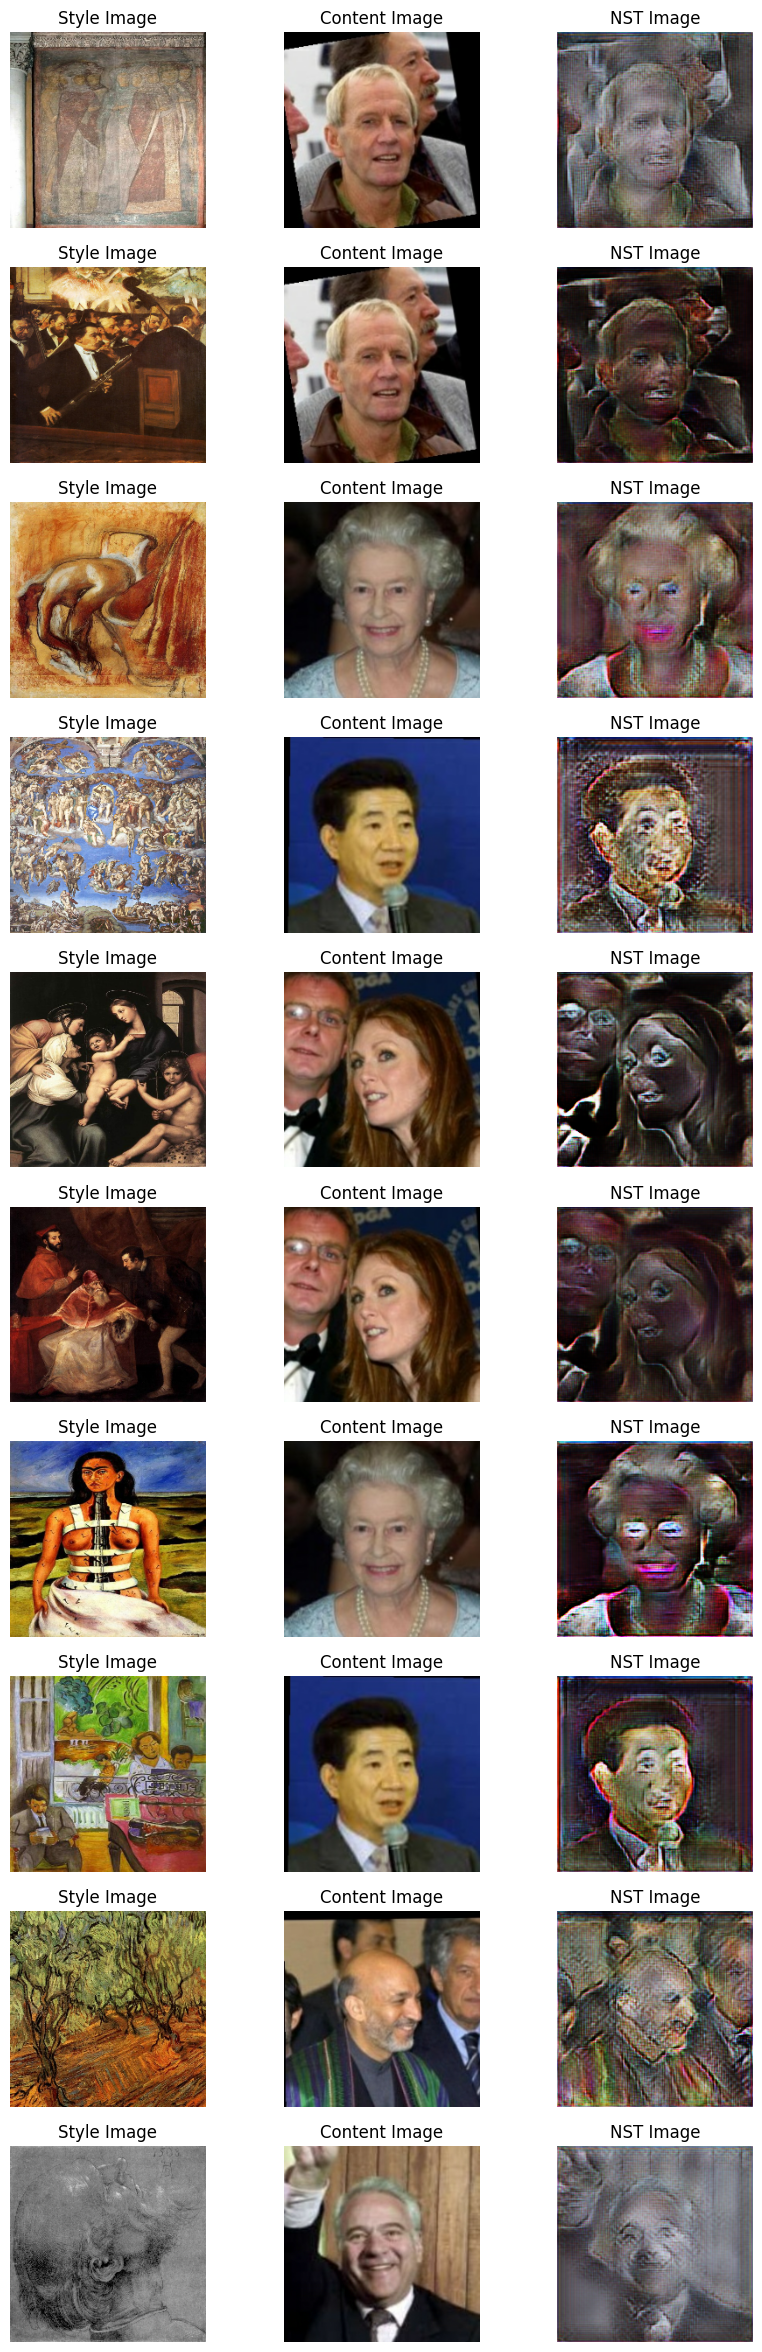

In [39]:
for style, content in test_ds.take(1):
    style_encoded = model.encoder(style)
    content_encoded = model.encoder(content)
    t = ada_in(style=style_encoded, content=content_encoded)
    reconstructed_image = model.decoder(t)
    fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 30))
    [ax.axis("off") for ax in np.ravel(axes)]

    for axis, style_image, content_image, reconstructed_image in zip(
        axes, style[0:10], content[0:10], reconstructed_image[0:10]
    ):
        (ax_style, ax_content, ax_reconstructed) = axis
        ax_style.imshow(style_image)
        ax_style.set_title("Style Image")
        ax_content.imshow(content_image)
        ax_content.set_title("Content Image")
        ax_reconstructed.imshow(reconstructed_image)
        ax_reconstructed.set_title("NST Image")

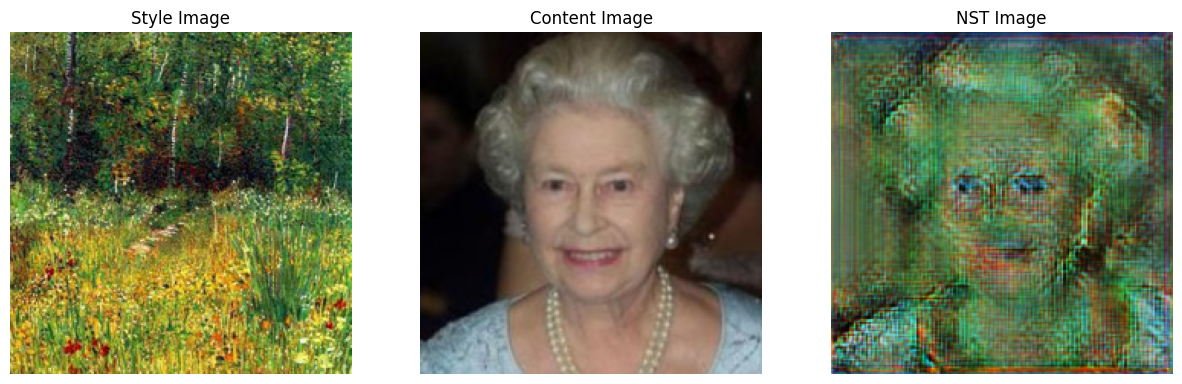

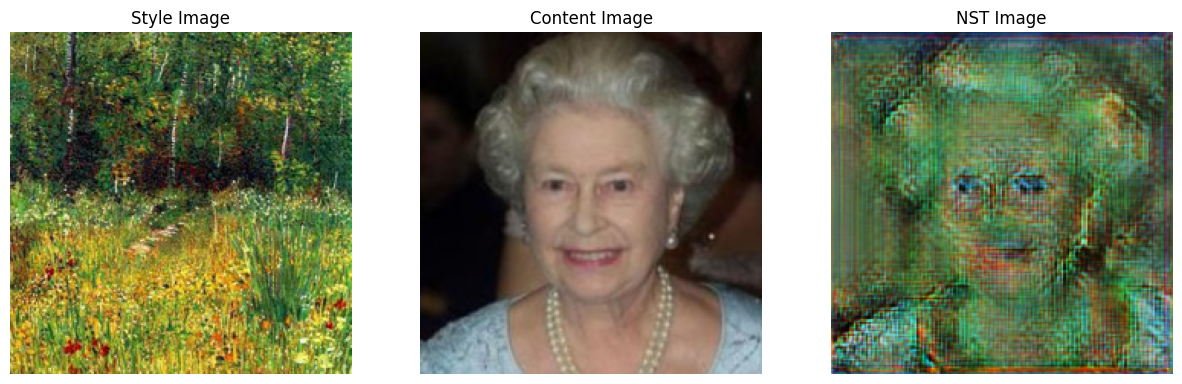

In [36]:
from PIL import Image
import numpy as np

def load_and_preprocess_image(path):
    # Load the image file
    image = Image.open(path)
    # Resize the image to match the input size expected by the model
    image = image.resize((224, 224))  # Adjusting to 224x224 as required by your model
    image = np.array(image)
    if image.shape[2] == 4:  # Check if the image has an alpha channel
        image = image[..., :3]  # Drop the alpha channel if present
    image = image / 255.0  # Normalize the pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image
import matplotlib.pyplot as plt
import tensorflow as tf

def display_images(style_image, content_image, reconstructed_image):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    img_titles = ['Style Image', 'Content Image', 'NST Image']
    images = [style_image, content_image, reconstructed_image]

    for ax, img, title in zip(axes, images, img_titles):
        # Using tf.squeeze to remove dimensions of size 1 from the shape of a tensor
        img = tf.squeeze(img)  # Adjusted for TensorFlow tensor
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

# Assuming you have already defined and processed 'style_image', 'content_image', and 'reconstructed_image'
# You can call display_images like this:
display_images(style_image, content_image, reconstructed_image)


# Adjusting paths if necessary, ensure they point to valid image files
style_image_path = '/content/drive/MyDrive/park-at-asnieres-in-spring-1887.jpg!Large.jpg'
content_image_path = '/content/lfw-funneled/lfw_funneled/Queen_Elizabeth_II/Queen_Elizabeth_II_0005.jpg'

# Load and preprocess images
style_image = load_and_preprocess_image(style_image_path)
content_image = load_and_preprocess_image(content_image_path)

# Assuming 'model' is defined elsewhere and has 'encoder' and 'decoder' methods
style_encoded = model.encoder(style_image)
content_encoded = model.encoder(content_image)

# Assume 'ada_in' is a function that combines style and content features
t = ada_in(style=style_encoded, content=content_encoded)

# Decode to get the NST (Neural Style Transfer) image
reconstructed_image = model.decoder(t)

# Display the images using the already defined function
display_images(style_image, content_image, reconstructed_image)
